In [1]:
from openai import OpenAI
from pathlib import Path
import fitz  # PyMuPDF
import pandas as pd
from tqdm import tqdm
import json
from dotenv import load_dotenv

from pdf2image import convert_from_path
import pytesseract
from PIL import Image
import tempfile
import os

import base64
import shutil

from joblib import Parallel, delayed



In [2]:
# Load OpenAI API key from .env file
load_dotenv()
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

# Paths
PDF_DIR = Path("pdf_folder")  # Ensure this path contains your PDFs
# OUTPUT_PATH = Path("results/classify_gpt_results1.csv")

In [3]:

# OCR 补救函数：用于从首页和末页图像提取文本
def extract_text_with_ocr(pdf_path, front_n=5, back_n=5, dpi=300):
    import warnings
    from pdf2image.exceptions import PDFPageCountError
    try:
        with tempfile.TemporaryDirectory() as path:
            try:
                images = convert_from_path(str(pdf_path), dpi=dpi, output_folder=path)
            except PDFPageCountError as e:
                return f"OCR ERROR: PDF structure invalid – {str(e)}"
            except Exception as e:
                return f"OCR ERROR: {str(e)}"

            total_pages = len(images)
            if total_pages == 0:
                return "OCR ERROR: No images extracted"

            selected = images[:front_n] + images[-back_n:]
            texts = []
            for img in selected:
                img = img.convert("L")  # 灰度增强
                text = pytesseract.image_to_string(img, lang="eng")
                texts.append(text)
            return "\n".join(texts)

    except Exception as e:
        return f"OCR ERROR (outer): {str(e)}"

In [4]:
# def extract_front_back_text(pdf_path, front_n=5, back_n=5):
#     try:
#         doc = fitz.open(pdf_path)
#         texts = []
#         for i in range(min(front_n, len(doc))):
#             texts.append(doc[i].get_text())
#         for i in range(max(0, len(doc) - back_n), len(doc)):
#             texts.append(doc[i].get_text())
#         doc.close()
#         full_text = "\n".join(texts)
#         if len(full_text.strip()) < 50:
#             raise ValueError("Empty or invalid text, fallback to OCR.")
#         return full_text
#     except Exception as e:
#         print(f"⚠️ PyMuPDF failed on {pdf_path.name}, switching to OCR...")
#         return extract_text_with_ocr(pdf_path)
    
def extract_front_back_text(pdf_path, front_n=10, back_n=10, dpi=300):
    try:
        doc = fitz.open(str(pdf_path))
        texts = []
        for i in range(min(front_n, len(doc))):
            texts.append(doc[i].get_text())
        for i in range(max(0, len(doc) - back_n), len(doc)):
            texts.append(doc[i].get_text())
        doc.close()
        full_text = "\n".join(texts)
        if len(full_text.strip()) < 100:
            raise ValueError("Too short, fallback to OCR.")
        return full_text
    except Exception as e:
        print(f"⚠️ Fallback to OCR on: {pdf_path.name} due to {str(e)}")
        return extract_text_with_ocr(pdf_path, front_n, back_n, dpi)
    

In [10]:

def classify_report_type(text):
    system_prompt = "You are an expert in classification."
    user_prompt =f"""
The following text is extracted from a corporate report (first and last few pages).

Your tasks:

1. Classify the report into one of the following types:
- "sustainability report": The document primarily focuses on ESG, sustainability, CSR, or GRI/SDGs-related topics. It does NOT contain full audited financial statements.
- "annual report": The document primarily contains audited financial disclosures, such as income statements, cash flow statements, balance sheets, and auditor's reports. ESG content, if any, is limited or supplementary.
- "integrated report": The document includes BOTH complete financial disclosures and structured sustainability content within the same document.
- "other": The document does not meet the criteria for any of the above (e.g., regulatory compliance reports, environmental approvals, investor brochures, etc.)

2. Important judgment rules:
- Do NOT classify a "Corporate Social Responsibility Report", "Corporate Responsibility Report", or "CSR Report" as "integrated report" unless it also includes full audited financials.
- If the title contains "Annual Report" but the content lacks actual financial statements, do NOT classify it as "annual" or "integrated".
- References or summaries of financials are NOT sufficient — only classify based on complete financial statement inclusion.

3. If the document contains a distinct sustainability section (e.g. a chapter on ESG/CSR/GRI/SDGs content that constitutes more than 50% of a section), mark `has_sustainability_section = true`, and extract the section name if available.

Return a JSON object with the following fields:
{{
  "reasoning": "...",
  "report_type": "...",
  "has_sustainability_section": true/false,
  "sustainability_section_name": "..."
}}

Content:
{text}
"""
    
 
# 


    try:
        response = client.chat.completions.create(
            model="gpt-4.1-mini",
            messages=[
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": user_prompt}
            ],
            temperature=0
        )
        reply = response.choices[0].message.content
        parsed = json.loads(reply)
        return parsed.get("report_type", ""), parsed.get("has_sustainability_section", ""), parsed.get("sustainability_section_name", ""), parsed.get("reasoning", "")
    except Exception as e:
        return "ERROR", False, "", f"Exception: {e}"

In [11]:

def extract_company_or_publisher_with_gpt(text):
    import json

    # 第一阶段：提取公司名称、别名、国家
    primary_prompt = f"""
You are a corporate reporting analyst.

From the first and last pages of a corporate report, extract the following:
1. The **official company name** that issued the report.
2. A list of **other names** referring to the company (abbreviations, group name, acronyms, etc.).
3. The **country** where the company is headquartered.
4. A brief **reasoning** explaining your extraction.

Return a JSON object like this:
{{
  "company_name": "...",
  "other_names": ["...", "..."],
  "country": "...",
  "reasoning": "..."
}}

If the company name is not found, return:
{{
  "company_name": "UNKNOWN",
  "other_names": [],
  "country": "UNKNOWN",
  "reasoning": "No indication of the company in the text."
}}

Text:
{text}
"""

    try:
        response = client.chat.completions.create(
            model="gpt-4.1",  # 更稳定
            messages=[
                {"role": "system", "content": "You are an expert in ESG and corporate reporting."},
                {"role": "user", "content": primary_prompt}
            ],
            temperature=0
        )
        content = response.choices[0].message.content.strip()
        result = json.loads(content)
    except Exception as e:
        return {
            "company_name": "GPT_ERROR",
            "other_names": [],
            "country": "GPT_ERROR",
            "reasoning": str(e),
            "publisher": None
        }
    except json.JSONDecodeError:
        return {
            "company_name": "PARSE_ERROR",
            "other_names": [],
            "country": "PARSE_ERROR",
            "reasoning": f"Raw response: {content}",
            "publisher": None
        }

    # 第二阶段：若无法识别公司名，尝试提取 publisher
    if result.get("company_name", "").upper() == "UNKNOWN":
        try:
            secondary_prompt = f"""
This report was not issued by a company but possibly by a public institution or academic body.

From the following text, extract the **publisher** and return:
{{ "publisher": "..." }}

If not found:
{{ "publisher": "UNKNOWN" }}

Text:
{text}
"""
            response2 = client.chat.completions.create(
                model="gpt-4.1",
                messages=[
                    {"role": "system", "content": "You are an expert in institutional publishing."},
                    {"role": "user", "content": secondary_prompt}
                ],
                temperature=0
            )
            content2 = response2.choices[0].message.content.strip()
            pub_result = json.loads(content2)
            result["publisher"] = pub_result.get("publisher", "UNKNOWN")
        except Exception as e:
            result["publisher"] = f"GPT_ERROR: {str(e)}"
    else:
        result["publisher"] = None

    # 清理字段
    if result.get("company_name", "").upper() == "UNKNOWN":
        result["company_name"] = ""
    if not isinstance(result.get("other_names"), list):
        result["other_names"] = []
    if "country" not in result or not isinstance(result["country"], str):
        result["country"] = "UNKNOWN"

    return result

# def process_folder_with_gpt_and_type(pdf_folder, output_path):
#     results = []
#     pdf_folder = Path(pdf_folder)
#     pdf_files = list(pdf_folder.glob("*.pdf"))

#     for pdf in tqdm(pdf_files, desc="Classifying reports"):
#         text = extract_front_back_text(pdf)
#         result = extract_company_or_publisher_with_gpt(text)
#         results.append({
#             "file_name": pdf.name,
#             "company_name": result["company_name"],
#             "other_names": "; ".join(result.get("other_names", [])),  # 用分号拼接方便输出
#             "publisher": result.get("publisher", None),
#             "reasoning": result["reasoning"],
#             "country": result["country"],
#         })

#     df = pd.DataFrame(results)
#     df.to_csv(output_path, index=False)
#     print(f"✅ Saved to {output_path}")
#     return df

In [12]:

# ========== 4. 构造 Prompt ==========
def build_report_year_prompt(text):
    return f"""
You are an expert assistant helping to extract reporting years from corporate reports.

Please complete the following tasks after carefully reading the text below:

---

### Task 1: Identify any **fiscal year**, **reporting period**, or **financial year** expressions.

Common examples include:
- "for the year ended 31 December 2021"
- "reporting period: April 2021 – March 2022"
- "2011–14" or "FY2017"
- "2020 ESG highlights"
- "2013 Corporate Report"

---

### Task 2: Normalize each valid expression into a standardized format:

1. If the expression is a **single year**, like `"2013"` or `"FY2020"`, output `"2013"` or `"2020"` as-is.
2. If it is a **range of years only**, like `"2014–15"`, output `"2014 to 2015"`. Do **not** add months or days.
3. If full dates are mentioned (e.g., `"1st April 2020 – 31st March 2021"`), remove ordinal suffixes (`1st`, `2nd`, etc.) and format as:
   `"1 April 2020 to 31 March 2021"`
4. Always convert dashes ("–" or "-") to "to".
5. If month is provided but not day (e.g., `"April 2020 – March 2021"`), convert to `"April 2020 to March 2021"`.

---

### Task 3: Return a JSON in the following format:

If a valid reporting year expression is found:

{{
  "normalized_report_year": "your normalized result here",
  "original_expression": "copy the original matched expression",
  "source": "e.g. Page 1, main text"
}}

If no valid expression is found:

{{
  "normalized_report_year": null,
  "original_expression": null,
  "source": "NOT FOUND"
}}

Only output the JSON object. Do not add explanations or commentary.

---

Text:
{text}
"""

# ========== 5. Vision 模型辅助 ==========
def encode_image_to_base64(pil_image):
    with tempfile.NamedTemporaryFile(suffix=".png") as f:
        pil_image.save(f.name, format="PNG")
        with open(f.name, "rb") as image_file:
            return base64.b64encode(image_file.read()).decode("utf-8")

def extract_year_from_vision(pdf_path, page_limit=3):
    try:
        images = convert_from_path(pdf_path, dpi=200)
        for i, img in enumerate(images[:page_limit]):
            b64 = encode_image_to_base64(img)
            response = client.chat.completions.create(
                model="gpt-4o",
                messages=[
                    {"role": "user", "content": [
                        {"type": "text", "text": f"Please extract the fiscal year or reporting period from page {i+1}. Please return in this JSON format:\n"
                                                 "{\n  \"normalized_report_year\": \"...\",\n  \"original_expression\": \"...\",\n  \"source\": \"Page {i+1}, image-based\"\n}"},
                        {"type": "image_url", "image_url": {"url": f"data:image/png;base64,{b64}"}}
                    ]}
                ],
                max_tokens=300
            )
            content = response.choices[0].message.content
            parsed = json.loads(content.strip()) if content.strip().startswith("{") else eval(content.strip())
            if parsed.get("normalized_report_year"):
                return parsed
    except Exception as e:
        return {
            "normalized_report_year": None,
            "original_expression": None,
            "source": f"Vision ERROR: {e}"
        }
    return {
        "normalized_report_year": None,
        "original_expression": None,
        "source": "Vision NOT FOUND"
    }

# ========== 6. 主函数：先文本，再 Vision ==========
def extract_report_year(pdf_path):
    try:
        text = extract_front_back_text(pdf_path)
        prompt = build_report_year_prompt(text)
        response = client.chat.completions.create(
            model="gpt-4.1-mini",
            messages=[{"role": "user", "content": prompt}],
            temperature=0,
            max_tokens=500
        )
        content = response.choices[0].message.content
        parsed = json.loads(content.strip()) if content.strip().startswith("{") else eval(content.strip())
        if parsed.get("normalized_report_year"):
            return parsed
    except Exception as e:
        print(f"⚠️ GPT-4.1-mini failed on {Path(pdf_path).name}, fallback to Vision...")
    return extract_year_from_vision(pdf_path)



In [13]:
def process_pdf(pdf_path):
    text = extract_front_back_text(pdf_path)

    report_type, sustainability,sustainability_name,classify_reasoning = classify_report_type(text)
    year = extract_report_year(pdf_path)
    company = extract_company_or_publisher_with_gpt(text)

    return {
        "filename": pdf_path.name,
        # "report_type": rtype.get("report_type"),
        # "has_sustainability_section": rtype.get("has_sustainability_section"),
        # "sustainability_section_name": rtype.get("sustainability_section_name"),
        "report_type": report_type,
        "has_sustainability_section": sustainability,
        "sustainability_section_name": sustainability_name,
        "classify_reasoning": classify_reasoning,
        "normalized_report_year": year.get("normalized_report_year"),
        "original_expression": year.get("original_expression"),
        "year_source": year.get("source"),
        "company_name": company.get("company_name"),
        "other_names": "; ".join(company.get("other_names", [])),
        "publisher": company.get("publisher"),
        "country": company.get("country"),
        "reasoning": company.get("reasoning")
    }

In [ ]:
# 设置路径
from concurrent.futures import ThreadPoolExecutor
pdf_dir = Path("pdf_folder")
output_path = Path("results/full_pipeline_output_parre.csv")
os.makedirs(output_path.parent, exist_ok=True)

# 收集所有 PDF 文件
pdf_files = list(pdf_dir.glob("*.pdf"))

# 定义最大线程数（推荐 5–10）
MAX_WORKERS = 5

# 使用线程池并行执行
with ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
    results = list(tqdm(executor.map(process_pdf, pdf_files), total=len(pdf_files), desc="🚀 Processing PDFs"))

# 保存结果
df = pd.DataFrame(results)
df.to_csv(output_path, index=False)
print(f"✅ Done! Results saved to: {output_path}")

🚀 Processing PDFs:  19%|█▉        | 247/1277 [12:03<36:08,  2.11s/it]  

⚠️ Fallback to OCR on: Unknown_adbi-managing-transition-low-carbon-economy_087is5zy.pdf due to Too short, fallback to OCR.


🚀 Processing PDFs:  19%|█▉        | 248/1277 [12:04<35:03,  2.04s/it]

⚠️ Fallback to OCR on: Unknown_adbi-managing-transition-low-carbon-economy_087is5zy.pdf due to Too short, fallback to OCR.


🚀 Processing PDFs:  20%|█▉        | 253/1277 [12:13<29:07,  1.71s/it]

⚠️ Fallback to OCR on: Unknown_2014SustainRpt_FNL_lr_7mrwsfm7.pdf due to Too short, fallback to OCR.


🚀 Processing PDFs:  20%|█▉        | 254/1277 [12:14<26:19,  1.54s/it]

⚠️ Fallback to OCR on: Unknown_2014SustainRpt_FNL_lr_7mrwsfm7.pdf due to Too short, fallback to OCR.
⚠️ GPT-4.1-mini failed on Unknown_2014SustainRpt_FNL_lr_7mrwsfm7.pdf, fallback to Vision...


🚀 Processing PDFs:  28%|██▊       | 354/1277 [17:05<48:29,  3.15s/it]  

⚠️ Fallback to OCR on: Hansae_Yes24_Holdings_Co_Ltd_HANSAE20YES2420HOLDINGS20ESG20REPORT202022_th5kzsfk.pdf due to Too short, fallback to OCR.


🚀 Processing PDFs:  28%|██▊       | 357/1277 [17:08<32:51,  2.14s/it]

⚠️ Fallback to OCR on: Hansae_Yes24_Holdings_Co_Ltd_HANSAE20YES2420HOLDINGS20ESG20REPORT202022_th5kzsfk.pdf due to Too short, fallback to OCR.


🚀 Processing PDFs:  33%|███▎      | 423/1277 [20:31<44:53,  3.15s/it]  

⚠️ Fallback to OCR on: Home_Inns__Hotels_Management_Inc_Barclays_Bank_PLC_Annual_Report_202014_5lj1epic.pdf due to Too short, fallback to OCR.
⚠️ Fallback to OCR on: Home_Inns__Hotels_Management_Inc_Barclays_Bank_PLC_Annual_Report_202014_5lj1epic.pdf due to Too short, fallback to OCR.


🚀 Processing PDFs:  35%|███▌      | 453/1277 [21:38<28:53,  2.10s/it]  

⚠️ GPT-4.1-mini failed on Equiniti_Group_PLC_equiniti_annual_report_2013_sc3sfin8.pdf, fallback to Vision...
⚠️ GPT-4.1-mini failed on Indraprastha_Medical_Corp_IMCL-Annual-Report-2021-22_wm0azpdc.pdf, fallback to Vision...
⚠️ GPT-4.1-mini failed on Avon_Protection_plc_LSE_AVON_2018_vl18pd8d.pdf, fallback to Vision...
⚠️ GPT-4.1-mini failed on Unknown_202020Ohio20Treasurer20Annual20Report201_y9weygfp.pdf, fallback to Vision...
⚠️ GPT-4.1-mini failed on Dis-Chem_Pharmacies_Ltd__74gpygvx.pdf, fallback to Vision...


🚀 Processing PDFs:  36%|███▌      | 457/1277 [22:21<1:12:32,  5.31s/it]

⚠️ GPT-4.1-mini failed on Absolute_Software_Corp_abt-csr-report_chc5albm.pdf, fallback to Vision...


🚀 Processing PDFs:  38%|███▊      | 491/1277 [24:02<41:57,  3.20s/it]  

⚠️ Fallback to OCR on: Unknown_adp07-sus-fr_95qx6prh.pdf due to Too short, fallback to OCR.


🚀 Processing PDFs:  39%|███▊      | 494/1277 [24:11<38:47,  2.97s/it]

⚠️ Fallback to OCR on: Unknown_adp07-sus-fr_95qx6prh.pdf due to Too short, fallback to OCR.


🚀 Processing PDFs:  41%|████▏     | 528/1277 [25:26<22:27,  1.80s/it]

⚠️ GPT-4.1-mini failed on Essential_Utilities_Inc_34ecde9c-8434-4849-a903-48114b59c681_f5v52887.pdf, fallback to Vision...


🚀 Processing PDFs:  52%|█████▏    | 668/1277 [32:29<28:43,  2.83s/it]  

⚠️ Fallback to OCR on: Armstrong_Flooring_Inc_SustainabilityReport-2020_kot54emv.pdf due to Too short, fallback to OCR.


🚀 Processing PDFs:  52%|█████▏    | 669/1277 [32:29<21:01,  2.07s/it]

⚠️ Fallback to OCR on: Armstrong_Flooring_Inc_SustainabilityReport-2020_kot54emv.pdf due to Too short, fallback to OCR.


🚀 Processing PDFs:  53%|█████▎    | 674/1277 [32:42<27:23,  2.72s/it]

⚠️ GPT-4.1-mini failed on AWG_PLC_oal-accounts-31-3-2021_01mspido.pdf, fallback to Vision...


🚀 Processing PDFs:  55%|█████▍    | 701/1277 [33:54<16:27,  1.71s/it]  

⚠️ GPT-4.1-mini failed on Unknown_2022-esg-report-update_grll1p8t.pdf, fallback to Vision...


🚀 Processing PDFs:  55%|█████▍    | 702/1277 [34:34<1:36:07, 10.03s/it]

⚠️ GPT-4.1-mini failed on Somfy_SA_2019annual_financial_report_hhukjl3l.pdf, fallback to Vision...


🚀 Processing PDFs:  57%|█████▋    | 732/1277 [35:33<19:15,  2.12s/it]  

⚠️ GPT-4.1-mini failed on Unknown_51719-12Co-12412560A3121758840E-Gl_1j0j409z.pdf, fallback to Vision...


🚀 Processing PDFs:  60%|█████▉    | 766/1277 [37:20<17:42,  2.08s/it]  

⚠️ Fallback to OCR on: Tam_Jai_International_Co_Ltd_2022083101184_go5rbp4a.pdf due to Too short, fallback to OCR.


🚀 Processing PDFs:  60%|██████    | 768/1277 [37:28<21:28,  2.53s/it]

⚠️ Fallback to OCR on: Tam_Jai_International_Co_Ltd_2022083101184_go5rbp4a.pdf due to Too short, fallback to OCR.


🚀 Processing PDFs:  70%|██████▉   | 890/1277 [43:22<16:55,  2.62s/it]

⚠️ Fallback to OCR on: Hyosung_Corp_SR_2020_en_8g98j6gk.pdf due to Too short, fallback to OCR.


🚀 Processing PDFs:  70%|██████▉   | 892/1277 [43:31<19:33,  3.05s/it]

⚠️ Fallback to OCR on: Hyosung_Corp_SR_2020_en_8g98j6gk.pdf due to Too short, fallback to OCR.


🚀 Processing PDFs:  76%|███████▌  | 968/1277 [47:08<12:26,  2.42s/it]

⚠️ GPT-4.1-mini failed on Siltronic_AG_20220309_Siltronic_Non-financial_Report_2021_qxyku58i.pdf, fallback to Vision...
⚠️ Fallback to OCR on: Boryung_Corporation_EBB3B4EBA0B920ECA780EC868DEAB080EB8AA5EAB2BDEC9881EBB3B4EAB3A0EC849CEC9881EBACB8_ebpit5lz.pdf due to Too short, fallback to OCR.


🚀 Processing PDFs:  76%|███████▌  | 969/1277 [47:20<24:34,  4.79s/it]

⚠️ Fallback to OCR on: Boryung_Corporation_EBB3B4EBA0B920ECA780EC868DEAB080EB8AA5EAB2BDEC9881EBB3B4EAB3A0EC849CEC9881EBACB8_ebpit5lz.pdf due to Too short, fallback to OCR.


🚀 Processing PDFs:  77%|███████▋  | 982/1277 [48:02<15:26,  3.14s/it]

⚠️ Fallback to OCR on: Arvind_Ltd_Arvind_AR_2022-23_0_iwp4673c.pdf due to Too short, fallback to OCR.
⚠️ Fallback to OCR on: Arvind_Ltd_Arvind_AR_2022-23_0_iwp4673c.pdf due to Too short, fallback to OCR.


🚀 Processing PDFs:  86%|████████▌ | 1100/1277 [53:47<07:22,  2.50s/it]

⚠️ Fallback to OCR on: EKI_Energy_Services_Limited_69298543284_zj7y1tjh.pdf due to Too short, fallback to OCR.


🚀 Processing PDFs:  86%|████████▋ | 1103/1277 [53:59<08:26,  2.91s/it]

⚠️ Fallback to OCR on: EKI_Energy_Services_Limited_69298543284_zj7y1tjh.pdf due to Too short, fallback to OCR.


🚀 Processing PDFs:  88%|████████▊ | 1118/1277 [55:11<10:55,  4.12s/it]

⚠️ Fallback to OCR on: Unknown_23076_Whitbread_AR2020_web_0v2mxh4f.pdf due to Too short, fallback to OCR.


🚀 Processing PDFs:  88%|████████▊ | 1120/1277 [55:15<08:55,  3.41s/it]

⚠️ Fallback to OCR on: Unknown_23076_Whitbread_AR2020_web_0v2mxh4f.pdf due to Too short, fallback to OCR.


🚀 Processing PDFs:  89%|████████▉ | 1138/1277 [56:15<07:16,  3.14s/it]

⚠️ GPT-4.1-mini failed on Unknown_2022033100197_w4pq05yp.pdf, fallback to Vision...


🚀 Processing PDFs:  89%|████████▉ | 1141/1277 [56:21<05:58,  2.64s/it]

⚠️ GPT-4.1-mini failed on Bell_Food_Group_AG__ju45deo3.pdf, fallback to Vision...
⚠️ GPT-4.1-mini failed on Unknown_2022-MSC-Industrial-Supply-Inc-ESG-Report_klcgaob8.pdf, fallback to Vision...
⚠️ GPT-4.1-mini failed on Fujikura_Ltd_csr2020_all_ehx85wml.pdf, fallback to Vision...
⚠️ GPT-4.1-mini failed on Miyoshi_Ltd_Sustainability20Report202021_gmwjwp9p.pdf, fallback to Vision...


🚀 Processing PDFs:  94%|█████████▍| 1205/1277 [1:00:19<04:52,  4.07s/it]

⚠️ Fallback to OCR on: Unknown_2023042101335_kyzhtmjn.pdf due to Too short, fallback to OCR.
⚠️ Fallback to OCR on: Unknown_2023042101335_kyzhtmjn.pdf due to Too short, fallback to OCR.


🚀 Processing PDFs:  99%|█████████▉| 1264/1277 [1:03:06<00:34,  2.63s/it]

⚠️ Fallback to OCR on: BASF_SE_2012_BASF_Report_lmq79gwn.pdf due to Too short, fallback to OCR.


🚀 Processing PDFs:  99%|█████████▉| 1266/1277 [1:03:07<00:20,  1.82s/it]

⚠️ Fallback to OCR on: BASF_SE_2012_BASF_Report_lmq79gwn.pdf due to Too short, fallback to OCR.


🚀 Processing PDFs: 100%|██████████| 1277/1277 [1:03:41<00:00,  2.99s/it]

✅ Done! Results saved to: results/full_pipeline_output_parrel .csv


年份对比

In [24]:
import pandas as pd
import re

# === 1. 加载数据 ===
gpt_df = pd.read_csv("results/full_pipeline_output_parrel .csv")  # GPT提取结果
label_df = pd.read_excel("check/rfyear_annotation.xlsx")            # 标注结果

# === 2. 重命名列对齐、合并（按文件名）===
gpt_df.rename(columns={"filename": "pdf_name", "report_year": "normalized_report_year"}, inplace=True)
merged = pd.merge(label_df, gpt_df, on="pdf_name", how="inner")

# === 3. 清洗文本：空值转空串，大小写、空格、换行处理 ===
def clean_text(s):
    if pd.isna(s): return ""
    return str(s).strip().lower().replace("\n", " ")

merged["normalized_report_year"] = merged["normalized_report_year"].apply(clean_text)
merged["chosen_rfyear"] = merged["chosen_rfyear"].apply(clean_text)

# === 4. 定义辅助函数 ===
import re

def normalize_year_text(s):
    if not s:
        return ""
    s = s.lower().strip()
    
    # 替换常见连字符为统一格式
    s = s.replace("–", " to ").replace("-", " to ").replace("/", " to ")

    # 清除无效字符
    s = re.sub(r'[\(\)\[\],;:]', ' ', s)
    s = re.sub(r'\s+', ' ', s)

    # fy 缩写处理：fy2020 或 fy 2020 → 2020
    s = re.sub(r'\bfy\s*(\d{4})\b', r'\1', s)                   # fy 2020 → 2020
    s = re.sub(r'\bfy\s*(\d{2})\b', lambda m: f"20{m.group(1)}", s)  # fy 19 → 2019

    # 区间格式处理：2020 to 21 → 2020 to 2021
    s = re.sub(r'\b(20\d{2})\s+to\s+(\d{2})\b', lambda m: f"{m.group(1)} to 20{m.group(2)}", s)

    # 区间格式处理：2020–2021、2020-2021、fy2020 to 2021 → 2020 to 2021
    s = re.sub(r'\b(20\d{2})\s*to\s*(20\d{2})\b', r'\1 to \2', s)
    s = re.sub(r'\b(20\d{2})\s+to\s+20\d{2}', r'\g<0>', s)

    # 清理序数词
    s = re.sub(r'\b(\d{1,2})(st|nd|rd|th)\b', r'\1', s)

    return s.strip()

def extract_years(s):
    return sorted(set(re.findall(r'\b(20\d{2}|19\d{2})\b', s)))

def is_fuzzy_match(a, b):
    a_norm = normalize_year_text(a)
    b_norm = normalize_year_text(b)
    if a_norm == b_norm:
        return True

    # 提取年份集合
    a_years = extract_years(a_norm)
    b_years = extract_years(b_norm)

    if not a_years or not b_years:
        return False

    # 排序后再比较
    a_sorted = sorted(set(a_years))
    b_sorted = sorted(set(b_years))

    # 完全一致或包含
    if a_sorted == b_sorted:
        return True
    if len(a_sorted) == 1 and a_sorted[0] in b_sorted:
        return True
    if len(b_sorted) == 1 and b_sorted[0] in a_sorted:
        return True

    # 仅一个年份时允许±1
    if len(a_sorted) == 1 and len(b_sorted) == 1 and abs(int(a_sorted[0]) - int(b_sorted[0])) <= 1:
        return True

    return False

# === 5. 应用模糊匹配函数 ===
merged["fuzzy_match"] = merged.apply(lambda row: is_fuzzy_match(row["normalized_report_year"], row["chosen_rfyear"]), axis=1)

# === 6. 计算准确率 ===
total = len(merged)
correct = merged["fuzzy_match"].sum()
accuracy = correct / total

print(f"✅ number of combine samples：{total}")
print(f"✅ correct matches：{correct}")
print(f"✅ Fuzzy Accuracy：{accuracy:.2%}")

# === 7. 保存结果 ===
merged[["pdf_name", "chosen_rfyear", "normalized_report_year", "fuzzy_match"]].to_csv("pipeline_eval/year_comparison.csv", index=False)

✅ number of combine samples：224
✅ correct matches：189
✅ Fuzzy Accuracy：84.38%


In [26]:
import pandas as pd
import re

# === 1. 加载数据 ===
gpt_df = pd.read_csv("results/full_pipeline_output_parrel .csv")  # GPT提取结果
label_df = pd.read_excel("check/rfyear_annotation.xlsx")            # 标注结果

# === 2. 重命名列对齐、合并（按文件名）===
gpt_df.rename(columns={"filename": "pdf_name", "report_year": "normalized_report_year"}, inplace=True)
merged = pd.merge(label_df, gpt_df, on="pdf_name", how="inner")
merged = merged.drop_duplicates(subset="pdf_name", keep="first")

# === 3. 清洗文本：空值转空串，大小写、空格、换行处理 ===
def clean_text(s):
    if pd.isna(s): return ""
    return str(s).strip().lower().replace("\n", " ")

merged["normalized_report_year"] = merged["normalized_report_year"].apply(clean_text)
merged["chosen_rfyear"] = merged["chosen_rfyear"].apply(clean_text)

# === 4. 定义辅助函数 ===
import re

def normalize_year_text(s):
    if not s:
        return ""
    s = s.lower().strip()
    
    # 替换常见连字符为统一格式
    s = s.replace("–", " to ").replace("-", " to ").replace("/", " to ")

    # 清除无效字符
    s = re.sub(r'[\(\)\[\],;:]', ' ', s)
    s = re.sub(r'\s+', ' ', s)

    # fy 缩写处理：fy2020 或 fy 2020 → 2020
    s = re.sub(r'\bfy\s*(\d{4})\b', r'\1', s)                   # fy 2020 → 2020
    s = re.sub(r'\bfy\s*(\d{2})\b', lambda m: f"20{m.group(1)}", s)  # fy 19 → 2019

    # 区间格式处理：2020 to 21 → 2020 to 2021
    s = re.sub(r'\b(20\d{2})\s+to\s+(\d{2})\b', lambda m: f"{m.group(1)} to 20{m.group(2)}", s)

    # 区间格式处理：2020–2021、2020-2021、fy2020 to 2021 → 2020 to 2021
    s = re.sub(r'\b(20\d{2})\s*to\s*(20\d{2})\b', r'\1 to \2', s)
    s = re.sub(r'\b(20\d{2})\s+to\s+20\d{2}', r'\g<0>', s)

    # 清理序数词
    s = re.sub(r'\b(\d{1,2})(st|nd|rd|th)\b', r'\1', s)

    return s.strip()

def extract_years(s):
    return sorted(set(re.findall(r'\b(20\d{2}|19\d{2})\b', s)))

def is_fuzzy_match(a, b):
    a_norm = normalize_year_text(a)
    b_norm = normalize_year_text(b)
    if a_norm == b_norm:
        return True

    # 提取年份集合
    a_years = extract_years(a_norm)
    b_years = extract_years(b_norm)

    if not a_years or not b_years:
        return False

    # 排序后再比较
    a_sorted = sorted(set(a_years))
    b_sorted = sorted(set(b_years))

    # 完全一致或包含
    if a_sorted == b_sorted:
        return True
    if len(a_sorted) == 1 and a_sorted[0] in b_sorted:
        return True
    if len(b_sorted) == 1 and b_sorted[0] in a_sorted:
        return True

    # 仅一个年份时允许±1
    if len(a_sorted) == 1 and len(b_sorted) == 1 and abs(int(a_sorted[0]) - int(b_sorted[0])) <= 1:
        return True

    return False

# === 5. 应用模糊匹配函数 ===
merged["fuzzy_match"] = merged.apply(lambda row: is_fuzzy_match(row["normalized_report_year"], row["chosen_rfyear"]), axis=1)

# === 6. 计算准确率 ===
total = len(merged)
correct = merged["fuzzy_match"].sum()
accuracy = correct / total

print(f"✅ number of combine samples：{total}")
print(f"✅ correct matches：{correct}")
print(f"✅ Fuzzy Accuracy：{accuracy:.2%}")

# === 7. 保存结果 ===
merged[["pdf_name", "chosen_rfyear", "normalized_report_year", "fuzzy_match"]].to_csv("pipeline_eval/year_comparison1.csv", index=False)

✅ number of combine samples：165
✅ correct matches：139
✅ Fuzzy Accuracy：84.24%


name对比

In [19]:
import pandas as pd
from difflib import SequenceMatcher
import re
import ast
import pycountry

# === Step 1: 加载文件 ===
df_pred = pd.read_csv("results/full_pipeline_output_parrel .csv")  # 包含 company_name、other_names
df_true = pd.read_csv("check/matching_gabarito_with_pdfs2.csv")  # 包含 name_2
df_pred["filename"] = df_pred["filename"].str.strip()
df_true["filename"] = df_true["pdf_path"].str.strip()

df_merged = pd.merge(df_pred, df_true, on="filename", how="inner")

# === Step 2: 清洗函数 ===
def _clean_name(name: str) -> str:
    if pd.isna(name):
        return ""
    name = name.lower()
    name = re.sub(r"\([^()]*\)", "", name)
    name = re.sub(r"[^\w\d\s]", "", name)
    suffixes = [
        " company", " companies", " corporation", " incorporated", " corp", " llc", " ltd", " inc", 
        " oyj", " intl", " sa", " lp", " spa", " sanv", " nv", " plc", " nvsa", " ptd", 
        " int", " international", "limited", "group", "the ", " holdings", " co"
    ]
    for suffix in suffixes:
        name = name.replace(suffix, "")
    return re.sub(r"\s+", " ", name).strip()

def fuzzy_match(a, b):
    return SequenceMatcher(None, a, b).ratio()

def normalize_country_name(name):
    if pd.isna(name) or not isinstance(name, str):
        return ""
    name = name.strip().lower()
    try:
        # 先尝试国家简称
        country = pycountry.countries.get(alpha_2=name.upper())
        if country:
            return country.name.lower()
        # 再尝试国家全称
        country = pycountry.countries.search_fuzzy(name)[0]
        return country.name.lower()
    except:
        return name.lower()

def word_overlap_match(name1, name2):
    """返回两个名字中单词交集是否显著（≥1个有效关键词）"""
    stopwords = {"group", "holdings", "company", "limited", "corporation", "inc", "co"}
    words1 = set(re.findall(r"\b\w+\b", name1.lower())) - stopwords
    words2 = set(re.findall(r"\b\w+\b", name2.lower())) - stopwords
    return len(words1 & words2) > 0

# === Step 3: 匹配函数 ===
def get_best_match(row):
    target = _clean_name(row["name_2"])
    main_name = _clean_name(row["company_name"])
    best_score = fuzzy_match(main_name, target)
    best_source = "company_name"
    is_match = best_score >= 0.85

    # 尝试别名匹配
    candidates = []
    if "other_names" in row and pd.notna(row["other_names"]):
        raw = row["other_names"]
        try:
            if isinstance(raw, str):
                if raw.startswith("["):
                    candidates = ast.literal_eval(raw)
                else:
                    candidates = re.split(r"[;,\n]", raw)
            elif isinstance(raw, list):
                candidates = raw
        except Exception:
            candidates = []

    for alt in candidates:
        alt_clean = _clean_name(alt)
        score = fuzzy_match(alt_clean, target)
        if score > best_score:
            best_score = score
            is_match = score >= 0.85
            best_source = f"other_names ({alt.strip()})"

    # 第三阶段：若高分匹配失败，则使用国家宽松匹配 + 单词交集
    country1 = normalize_country_name(row.get("country", ""))
    country2 = normalize_country_name(row.get("loc", ""))
    
    relaxed_match_applied = False
    if not is_match and country1 and country1 == country2:
        if word_overlap_match(row["company_name"], row["name_2"]):
            is_match = True
            best_source = "relaxed_by_country_word_overlap"
            relaxed_match_applied = True

    return pd.Series([
        best_score,
        is_match,
        best_source,
        country1,
        country2,
        relaxed_match_applied
    ], index=[
        "fuzzy_score", "is_correct", "matched_by", 
        "normalized_country_pred", "normalized_country_true", 
        "used_relaxed_match"
    ])

# === Step 4: 应用匹配函数 ===
df_merged[[
    "fuzzy_score", "is_correct", "matched_by", 
    "normalized_country_pred", "normalized_country_true", 
    "used_relaxed_match"
]] = df_merged.apply(get_best_match, axis=1)

# === Step 5: 输出表格 ===
df_eval = df_merged[[
    "filename", "company_name", "other_names", "country", 
    "name_2", "loc", "normalized_country_pred", 
    "normalized_country_true", "fuzzy_score", "is_correct", 
    "matched_by", "used_relaxed_match"
]]
df_eval.to_csv("pipeline_eval/name_eval.csv", index=False)

# === Step 6: 显示准确率 ===
accuracy = df_eval["is_correct"].mean()
print(f"✅ Company name extraction accuracy (including loose country matching)：{accuracy:.2%}")

✅ Company name extraction accuracy (including loose country matching)：94.12%


In [32]:
import pandas as pd
from difflib import SequenceMatcher
import re
import ast

# === Step 1: 加载文件 ===
df_pred = pd.read_csv("results/full_pipeline_output_parrel .csv")  # 包含 company_name、other_names
df_true = pd.read_csv("check/matching_gabarito_with_pdfs2.csv")  # 包含 name_2
df_pred["filename"] = df_pred["filename"].str.strip()
df_true["filename"] = df_true["pdf_path"].str.strip()

df_merged = pd.merge(df_pred, df_true, on="filename", how="inner")

# === Step 2: 清洗函数 ===
def _clean_name(name: str) -> str:
    if pd.isna(name):
        return ""
    name = name.lower()
    name = re.sub(r"\([^()]*\)", "", name)
    name = re.sub(r"[^\w\d\s]", "", name)
    suffixes = [
        " company", " companies", " corporation", " incorporated", " corp", " llc", " ltd", " inc", 
        " oyj", " intl", " sa", " lp", " spa", " sanv", " nv", " plc", " nvsa", " ptd", 
        " int", " international", "limited", "group", "the ", " holdings", " co"
    ]
    for suffix in suffixes:
        name = name.replace(suffix, "")
    name = name.replace("é", "e").replace("  ", "").replace(" ", "")
    return re.sub(r"[^a-zA-Z0-9]", "", name)

# === Step 3: 匹配函数 ===
def fuzzy_match(clean_a, clean_b):
    return SequenceMatcher(None, clean_a, clean_b).ratio()
def get_best_match1(row):
    target = _clean_name(row["name_2"])
    main_name = _clean_name(row["company_name"])
    best_score = fuzzy_match(main_name, target)
    best_source = "company_name"

    # 解析 other_names：支持列表或字符串（自动切分）
    candidates = []
    if "other_names" in row and pd.notna(row["other_names"]):
        raw = row["other_names"]
        try:
            if isinstance(raw, str):
                if raw.startswith("["):  # 是列表字符串
                    candidates = ast.literal_eval(raw)
                else:  # 否则按常见分隔符切分
                    candidates = re.split(r"[;,\n]", raw)
            elif isinstance(raw, list):
                candidates = raw
        except Exception:
            candidates = []

    for alt in candidates:
        alt_clean = _clean_name(alt)
        score = fuzzy_match(alt_clean, target)
        if score > best_score:
            best_score = score
            best_source = f"other_names ({alt.strip()})"

    return pd.Series([best_score, best_score >= 0.85, best_source], index=["fuzzy_score", "is_correct", "matched_by"])
# === Step 4: 应用匹配函数 ===
df_merged[["fuzzy_score", "is_correct", "matched_by"]] = df_merged.apply(get_best_match1, axis=1)

# === Step 5: 输出评估表 ===
# df_eval = df_merged[["filename", "company_name", "other_names", "name_2", "fuzzy_score", "is_correct", "matched_by"]]
# df_eval.to_csv("eval/company_name_eval_with_alias.csv", index=False)

# === Step 6: 显示准确率 ===
accuracy = df_eval["is_correct"].mean()
print(f"✅ Company name extraction accuracy (including alias matching):{accuracy:.2%}")

✅ Company name extraction accuracy (including alias matching):94.12%


分类对比

分类对比

accuracy: 87.95%
✅ Saved to classification_comparison.xlsx
📊 detailed 

                       precision    recall  f1-score   support

        annual report      0.667     0.727     0.696        11
    integrated report      0.824     0.778     0.800        18
                other      1.000     0.250     0.400         4
sustainability report      0.943     1.000     0.971        50

             accuracy                          0.880        83
            macro avg      0.858     0.689     0.717        83
         weighted avg      0.883     0.880     0.870        83



/var/folders/9z/mm8bj8yn2yj6rk7vdlhpt07h0000gn/T/ipykernel_4176/2535642369.py:40: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_merged_cleaned = df_merged.applymap(clean_illegal_excel_chars)


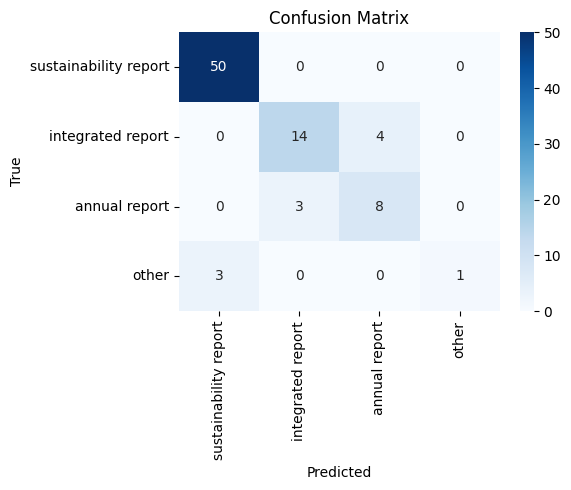

In [21]:
import pandas as pd

# ==== 1. 设置文件路径 ====
# 修改为你本地的绝对路径或相对路径
human_label_path = "check/pdf_classification.xlsx"
gpt_result_path = "results/full_pipeline_output_parrel .csv"

# ==== 2. 读取文件 ====
df_human = pd.read_excel(human_label_path)
df_gpt = pd.read_csv(gpt_result_path)

# ==== 3. 标准化列名，确保 filename 和 report_type 存在 ====
df_human.columns = [col.strip().lower() for col in df_human.columns]
df_gpt.columns = [col.strip().lower() for col in df_gpt.columns]

# ==== 4. 合并两个表 ====
df_merged = pd.merge(df_human, df_gpt, left_on="file_name",
    right_on="filename",
    how="left")


# ==== 6. 比较两个分类结果 ====
df_merged["report_type_human"] = df_merged["report_type_human"].str.strip().str.lower()
df_merged["report_type_gpt"] = df_merged["report_type"].str.strip().str.lower()
df_merged["is_correct"] = df_merged["report_type_human"] == df_merged["report_type_gpt"]

# ==== 7. 计算准确率 ====
accuracy = df_merged["is_correct"].mean()
print(f"accuracy: {accuracy:.2%}")

# ==== 8. 导出对比结果（可选）====
import re

def clean_illegal_excel_chars(text):
    if isinstance(text, str):
        return re.sub(r"[\x00-\x1F\x7F]", "", text)
    return text

# 清理非法字符
df_merged_cleaned = df_merged.applymap(clean_illegal_excel_chars)

# 再导出
df_merged_cleaned.to_excel("pipeline_eval/classification_comparison.xlsx", index=False)
print("✅ Saved to classification_comparison.xlsx")
# df_merged.to_excel("pipeline_eval/classification_comparison.xlsx", index=False)
# print("saved to classification_comparison_result.xlsx")

import sklearn
from sklearn.metrics import classification_report, confusion_matrix

# === 仅保留非空对比项（防止空值影响）===
valid = df_merged[~df_merged["report_type_human"].isna() & ~df_merged["report_type_gpt"].isna()]

# === 打印 classification report ===
report = classification_report(
    valid["report_type_human"], 
    valid["report_type_gpt"], 
    digits=3, 
    output_dict=False  # 改为 True 可返回字典
)
print("📊 detailed \n")
print(report)

# === 可视化混淆矩阵（可选）===
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(valid["report_type_human"], valid["report_type_gpt"], labels=valid["report_type_human"].unique())
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=valid["report_type_human"].unique(),
            yticklabels=valid["report_type_human"].unique())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

accuracy: 93.83%
✅ Saved to classification_comparison.xlsx
📊 detailed 

                       precision    recall  f1-score   support

        annual report      0.667     1.000     0.800         8
    integrated report      1.000     0.810     0.895        21
                other      1.000     0.500     0.667         2
sustainability report      0.980     1.000     0.990        50

             accuracy                          0.938        81
            macro avg      0.912     0.827     0.838        81
         weighted avg      0.955     0.938     0.939        81



/var/folders/9z/mm8bj8yn2yj6rk7vdlhpt07h0000gn/T/ipykernel_4176/1724669853.py:40: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_merged_cleaned = df_merged.applymap(clean_illegal_excel_chars)


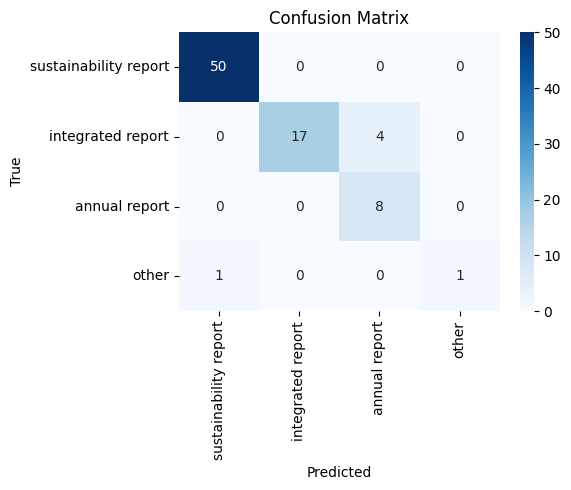

In [27]:
import pandas as pd

# ==== 1. 设置文件路径 ====
# 修改为你本地的绝对路径或相对路径
human_label_path = "check/pdf_classification.xlsx"
gpt_result_path = "results/full_pipeline_output_parrel .csv"

# ==== 2. 读取文件 ====
df_human = pd.read_excel(human_label_path)
df_gpt = pd.read_csv(gpt_result_path)

# ==== 3. 标准化列名，确保 filename 和 report_type 存在 ====
df_human.columns = [col.strip().lower() for col in df_human.columns]
df_gpt.columns = [col.strip().lower() for col in df_gpt.columns]

# ==== 4. 合并两个表 ====
df_merged = pd.merge(df_human, df_gpt, left_on="file_name",
    right_on="filename",
    how="left")
df_merged = df_merged.drop_duplicates(subset="file_name", keep="first")

# ==== 6. 比较两个分类结果 ====
df_merged["report_type_human"] = df_merged["report_type_human"].str.strip().str.lower()
df_merged["report_type_gpt"] = df_merged["report_type"].str.strip().str.lower()
df_merged["is_correct"] = df_merged["report_type_human"] == df_merged["report_type_gpt"]

# ==== 7. 计算准确率 ====
accuracy = df_merged["is_correct"].mean()
print(f"accuracy: {accuracy:.2%}")

# ==== 8. 导出对比结果（可选）====
import re

def clean_illegal_excel_chars(text):
    if isinstance(text, str):
        return re.sub(r"[\x00-\x1F\x7F]", "", text)
    return text

# 清理非法字符
df_merged_cleaned = df_merged.applymap(clean_illegal_excel_chars)

# 再导出
df_merged_cleaned.to_excel("pipeline_eval/classification_comparison2.xlsx", index=False)
print("✅ Saved to classification_comparison.xlsx")
# df_merged.to_excel("pipeline_eval/classification_comparison.xlsx", index=False)
# print("saved to classification_comparison_result.xlsx")

import sklearn
from sklearn.metrics import classification_report, confusion_matrix

# === 仅保留非空对比项（防止空值影响）===
valid = df_merged[~df_merged["report_type_human"].isna() & ~df_merged["report_type_gpt"].isna()]

# === 打印 classification report ===
report = classification_report(
    valid["report_type_human"], 
    valid["report_type_gpt"], 
    digits=3, 
    output_dict=False  # 改为 True 可返回字典
)
print("📊 detailed \n")
print(report)

# === 可视化混淆矩阵（可选）===
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(valid["report_type_human"], valid["report_type_gpt"], labels=valid["report_type_human"].unique())
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=valid["report_type_human"].unique(),
            yticklabels=valid["report_type_human"].unique())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()